# Task Learning

1. [Segmentation](#segmentation)

Compare different approaches to building a subgoal model.

2. [Prediction](#prediction)

Seek an online computation of posterior $p(z_i | s_i, a_i, z_{-i})$
    

## Segmentation <a class="anchor" id="segmentation"></a>

Segmentation uses Bayesian inference to discover latent subgoals in demonstration set. The three methods we will explore are
- [BNIRL](#bnirl) - Michini
- [MBNIRL](#mbnirl) - Modified BNIRL (a. la. mitch)
- [DPMIRL](#dpmirl) - Maske, still some concerns here
- [CP-IRL](#cpirl) - changepoint IRL, large acceleration (change in velocity vector direction)

Start by prepping the dataset and importing the `learning` module.

In [2]:
%matplotlib inline

In [3]:
import exc_analysis.learning as lrn
import exc_analysis.plotting as excplt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import trajectories
from jupyter_extras import log_progress

matplotlib.style.use('mitch-exp')

In [4]:
ls trial_data

manual_mitch_1101_2319.csv    manual_orlando_1102_1413.csv
manual_mitch_1101_2333.csv    manual_orlando_1102_1418.csv
manual_mitch_1102_1814.csv    manual_shyam_1101_2012.csv
manual_mitch_1102_1819.csv    manual_shyam_1102_1824.csv
manual_orlando_1102_1405.csv


In [5]:
# import trial data using compute_rate(), returns arrays of pos and rate
path = 'trial_data/' + 'manual_mitch_1102_1814.csv'

pos, rate_sm = lrn.compute_rate(path)
rate_sm = np.nan_to_num(rate_sm)

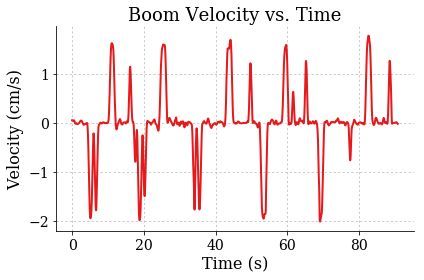

In [7]:
# Visualize trial
plt.figure()
ax = plt.gca()
plt.plot(pos[:-1, 0], rate_sm[:, 0])
plt.title('Boom Velocity vs. Time')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (cm/s)')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
plt.tight_layout()
# plt.savefig('figs/boom_velocity.pdf')

___

In [6]:
# label action primitives using get_action_primitives()
labels = np.zeros_like(rate_sm)

# thresholds for get_action_primitives()
thresholds = [0.2]*3 + [0.05]

# get_action_primitives() separates velocity into pos, neg, and approx zero
for i in range(len(labels)):
    labels[i] = lrn.get_action_primitives(rate_sm[i], thresholds[i])

In [7]:
labels

array([[ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.],
       [ 2.,  2.,  2., ...,  1.,  1.,  1.],
       [ 2.,  2.,  2., ...,  2.,  2.,  2.]])

<IPython.core.display.Javascript object>


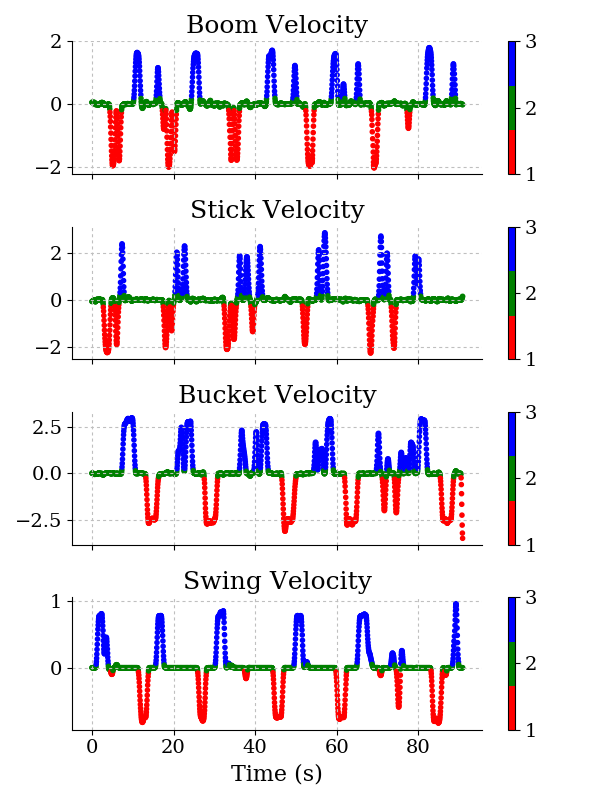

In [8]:
# plot the action pritives
fig = plt.figure(figsize=(6, 8))
# plt.title('Action Primitives for Each Actuator')
titles = [name + ' Velocity' for name in excplt.labels]

# bigax = fig.add_subplot(111, frameon=False)
plt.ylabel('Actuator Velocity (cm/s)')

# first plot so we can share axes
i = 3
ax3 = plt.subplot(4, 1, i+1)
plt.title(titles[i])
ax3.spines['right'].set_color('none')
ax3.spines['top'].set_color('none')
lrn.cluster_plot_new(pos[0][:-1], rate_sm[i], labels[i])
plt.xlabel('Time (s)')

for i in range(0, 3):
    ax = plt.subplot(4, 1, i+1, sharex=ax3)
    plt.title(titles[i])
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    lrn.cluster_plot_new(pos[0][:-1], rate_sm[i], labels[i])
    plt.setp(ax.get_xticklabels(), visible=False)


plt.tight_layout()
# plt.savefig('figs/action_primitives.pdf')

In [9]:
# count number of action primitives
labels_t = labels.transpose()
label_set = set([tuple(label) for label in labels_t])
print('There are %i unique action primitives.') % len(label_set)

There are 34 unique action primitives.


In [10]:
# assign numerical labels to each action primitive
action_primitives_set = tuple([list(label_set)[i] for i in range(len(label_set))])
action_primitives_set[:5]

((2.0, 3.0, 2.0, 2.0),
 (2.0, 2.0, 1.0, 1.0),
 (2.0, 3.0, 3.0, 2.0),
 (2.0, 2.0, 1.0, 2.0),
 (2.0, 3.0, 3.0, 1.0))

In [11]:
# we can query the index(es) of a certain action primitive
action_primitives_set.index((2, 2, 2, 2))

10

___

### Action Primitive Visualization

Visualize the action primitives categories during demonstration.

In [12]:
# query action class number for each time step
action_class = np.zeros((len(labels_t)))
for i, primitive in enumerate(labels_t):
    action_class[i] = action_primitives_set.index(tuple(primitive))

<IPython.core.display.Javascript object>


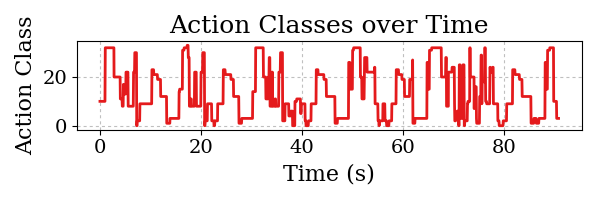

In [13]:
plt.figure(figsize=(6, 2))
plt.plot(pos[0][:-1], action_class)
plt.title('Action Classes over Time')
plt.xlabel('Time (s)')
plt.ylabel('Action Class')
plt.tight_layout()
# plt.savefig('figs/action_classes.pdf')

___

## Consolidate

Consolidate action primitive segments.

In [14]:
labels_t[:5]

array([[ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.]])

In [15]:
from itertools import groupby

In [16]:
# This might be easier to implement with pandas

indexes = []  # list of first indexes of each class 
action_temp = []  # list of action primitive lists for each class

# group by labels and give them a key
for key, group in groupby(zip(range(len(labels_t)), labels_t.tolist()), lambda x: x[1]):
    temp = next(group)
    indexes.append(temp[0])
    action_temp.append(temp[1])

action_condense = np.array(action_temp)

print('There are %i total action class transitions.' % len(indexes))

There are 161 total action class transitions.


In [17]:
# Get starting states for these action classes
states = np.array(pos[1:]).transpose()
states_condense = states[indexes]
states_condense.shape

(161, 4)

___

# 1.a. BNIRL <a class="anchor" id="bnirl"></a>

Bayesian nonparametric reinforcement learning, Michini *et. al.*

In [18]:
# For nice iterable status updates
from tqdm import tqdm
from scipy import stats

In [19]:
# Prep the state position array
assert states_condense.shape == action_condense.shape

In [25]:
%load_ext snakeviz

In [26]:
%%snakeviz
# Initialize the subgoal partition labels all to zero, and size to track convergence
partitions = [0]*(len(states_condense))
iters = 200
partition_dist = np.zeros((iters, len(states_condense)))
size = np.zeros((iters))

# Run BNIRL for _ iterations # eta works around 1e-7
for i in tqdm(range(iters)):
    partitions = lrn.bnirl_sampling_3(states_condense, partitions, 
                                      action_condense, verbose=False, 
                                      eta=3e-7)
    partition_dist[i] = np.array(partitions)
    size[i] = (len(set(partitions)))

100%|██████████| 200/200 [00:59<00:00,  3.82it/s]


 
*** Profile stats marshalled to file u'/var/folders/8s/78p6qhsn2f1c7s8mvtfv1pbm0000gn/T/tmpO5FXOl'. 


<IPython.core.display.Javascript object>


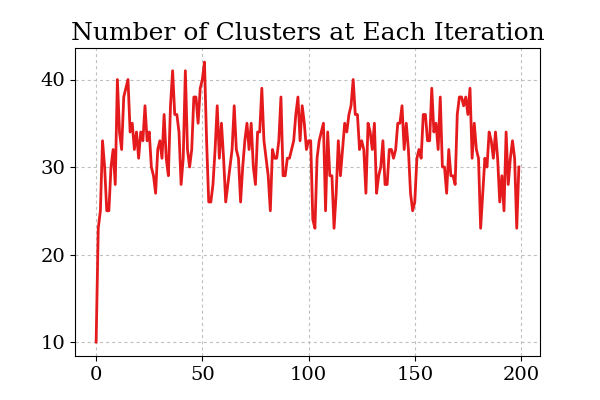

In [27]:
# Not too useful...
plt.figure()
plt.plot(size)
plt.title('Number of Clusters at Each Iteration')

In [28]:
partition_dist.shape

(200, 161)

In [49]:
# Build up modes array with j^th posterior modes *after* i^th iteration
modes = np.zeros(partition_dist.shape)
# modes = np.zeros(len(states_condense))

# Discard iterations for burn-in
brn = 20

# Store mode for each state over Gibbs sampling sweeps up to i^th iteration
for j in tqdm(range(len(partition_dist))): # 0-200
    for i in range(partition_dist.shape[1]): # 0-161
        modes[j, i] = stats.mode(partition_dist[:j+1, i])[0][0]
        
# Set of final mode posteriors and counts array: (mode_num, count)
mode_set = set([int(mode) for mode in modes[-1]])
counts = [(mode, np.count_nonzero(modes[-1]==mode)) for mode in mode_set]

# Top six modes
modes_trim = [x[1] for x in sorted(counts, key=lambda x: x[1])[:-6:-1]]

# Sort by descending counts
sorted(counts, key=lambda x: x[1])[::-1]

100%|██████████| 200/200 [00:48<00:00,  2.53it/s]


[(99, 49),
 (76, 43),
 (77, 33),
 (58, 10),
 (0, 8),
 (57, 6),
 (14, 4),
 (55, 3),
 (18, 2),
 (101, 2),
 (44, 1)]

<IPython.core.display.Javascript object>


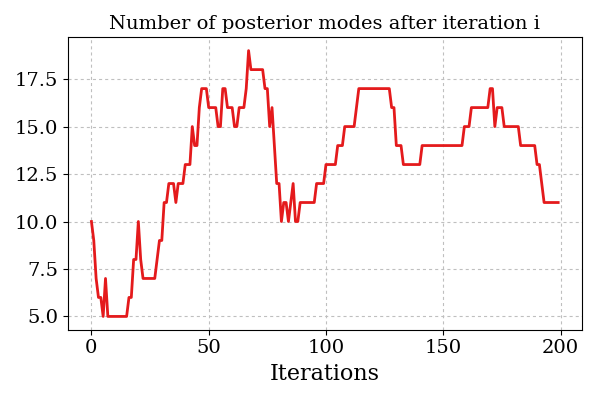

In [30]:
# Visualize number of posterior modes 
plt.figure()
plt.plot([len(set(mode)) for mode in modes])

plt.title('Number of posterior modes after iteration i', fontsize=14)
plt.xlabel('Iterations')

plt.tight_layout()

plt.savefig('figs/BNIRL_posterior_mode_convergence.pdf')

# Visualize BNIRL Subgoals

Compute forward kinematics and visualize subgoals.

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import exc_analysis.kinematics as kin

In [32]:
# Use vectorized forward kinematics function from exc_analysis.kinematics.py
states_condense_xyz = kin.forward_kin_array(states_condense)
states_condense_xyz.shape

(161, 3)

In [33]:
states_condense_xyz[:5]

array([[ 50.91466506,   0.        ,  26.6847627 ],
       [ 50.87806124,   0.        ,  26.65979231],
       [ 22.31710531,  45.66830869,  26.62904503],
       [  8.82270171,  58.29438757,  33.50275668],
       [  9.19659436,  60.36422027,  36.88895414]])

## Visualize all states in observation set

<IPython.core.display.Javascript object>


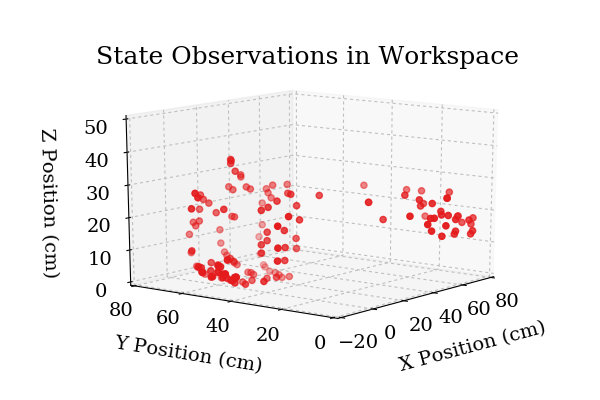

In [34]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('State Observations in Workspace')
plt.xlabel('X Position (cm)', family='serif', labelpad=15, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=15, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)

ax.scatter(*np.split(states_condense_xyz, 3, axis=1), zdir='z')
excplt.orient_plot(ax)

# plt.savefig('figs/state_observations.pdf', pad_inches=0.5)

___

In [35]:
states_condense.shape, action_condense.shape

((161, 4), (161, 4))

In [36]:
states_project = states_condense + (action_condense - 2)*np.array([0.1, 0.1, 0.1, 0.002])

states_project_xyz = kin.forward_kin_array(states_project)

states_project_xyz.shape

(161, 3)

<IPython.core.display.Javascript object>


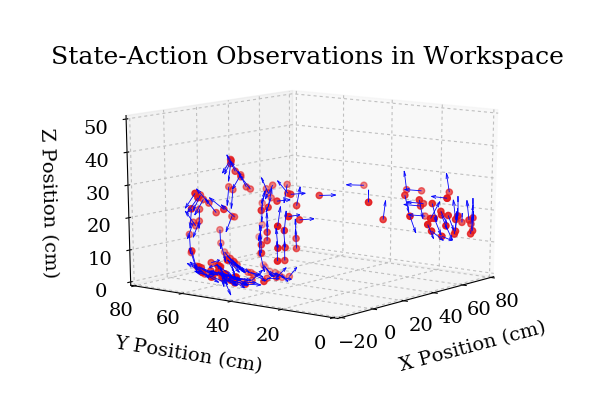

In [37]:
fig = plt.figure()
ax = fig.gca(projection='3d')
args = np.split(states_condense_xyz, 3, axis=1) + np.split(states_project_xyz - states_condense_xyz, 3, axis=1)

plt.title('State-Action Observations in Workspace')
plt.xlabel('X Position (cm)', family='serif', labelpad=15, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=15, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)

ax.scatter(*np.split(states_condense_xyz, 3, axis=1), zdir='z')
ax.quiver(*args, length=6, normalize=True, color='b', linewidth=0.6)

excplt.orient_plot(ax)

# plt.tight_layout()
plt.savefig('figs/state_action_quiver.pdf', pad_inches=0.5)

___

## Visualize Subgoals

In [38]:
# Extract subgoals in XYZ from states in XYZ
# NOTE SUBGOALS ARE ALSO BIASED TO GND FRAME

listed_modes = list(mode_set)
# listed_modes = modes_trim

subgoals_xyz = states_condense_xyz[listed_modes]
subgoals_xyz

array([[ 50.91466506,   0.        ,  26.6847627 ],
       [  8.84665454,  38.51068036,  17.23685451],
       [ 35.94563085,  16.018123  ,  20.07204146],
       [ 42.87765899,   6.10239455,  26.3706257 ],
       [ 44.4964001 ,   2.05461758,  25.48941987],
       [ 45.98754465,  -3.30147047,  22.22575538],
       [  8.34313158,  45.18051889,  13.47132331],
       [ 43.07150719,  11.82849322,  27.22168095],
       [  0.61393423,  69.48133335,  16.36855715],
       [  0.56703137,  72.19519208,  13.42243992],
       [  0.56207813,  71.56453877,   7.74653843]])

<IPython.core.display.Javascript object>


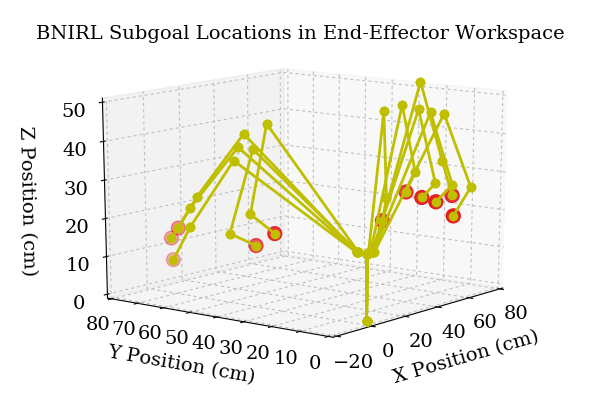

In [39]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('BNIRL Subgoal Locations in End-Effector Workspace', family='serif', fontsize=14)
plt.xlabel('X Position (cm)', family='serif', labelpad=10, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=10, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)
# plt.zlabel('z Position (cm)')

for j in listed_modes:
    trajectories.draw_exc(ax, states_condense[j], lw=2)

ax.scatter(*np.split(subgoals_xyz, 3, axis=1), s=100)

excplt.orient_plot(ax)
plt.tight_layout()
plt.savefig('figs/BNIRL_subgoals.pdf', pad_inches=0.5)

## Animate demonstration with subgoals

Test the draw_exc() func by animating all states. See exc-render.ipynb for examples of draw_exc(). 

In [21]:
from matplotlib.animation import FuncAnimation

In [41]:
states.shape

(1712, 4)

In [42]:
# Mode dict for colors
mode_color = dict()

for i, mode in enumerate(listed_modes):
    mode_color[mode] = i

In [43]:
colors = ['b', 'g', 'r', 'y', 'm', 'c']

Switch matplotlib backend for better GIF writing.

In [44]:
%matplotlib inline

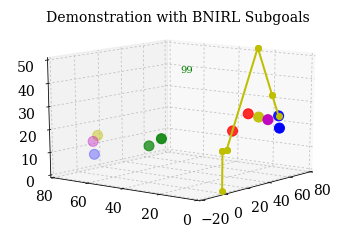

In [45]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# for i in mode_set - set([101, 149]):
#     trajectories.draw_exc(ax, states[i])

def update(i):
    plt.cla()
    plt.title('Demonstration with BNIRL Subgoals', family='serif', fontsize=14)
    ax.scatter(*np.split(subgoals_xyz, 3, axis=1), s=100, 
               c=[colors[mode_color[m] % 5] for m in mode_set])
    excplt.draw_exc(ax, states_condense[i])
    excplt.orient_plot(ax)
    sg_label = int(modes[-1, i])
    ax.text(60, 60, 40, sg_label, color=colors[mode_color[modes[-1, i]] % 5])

anim = FuncAnimation(fig, update, 
                     frames=range(0, len(states_condense)),
                     interval=200)

# plt.show()
anim.save('figs/BNIRL_subgoal_states.gif', dpi=80, writer='imagemagick')

Put it back now, yall

In [46]:
%matplotlib notebook

___

## Animate cluster formation

Show clusters over iteration of Gibbs Sampling

### Popular subgoals

Clusters represent subgoals after i'th iteration, cluster size represents number of states seeking that subgoal after i'th iteration

In [50]:
modes

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ..., 
       [ 99.,  76.,  77., ...,  77.,  76.,  77.],
       [ 99.,  76.,  77., ...,  77.,  76.,  77.],
       [ 99.,  76.,  77., ...,  77.,  76.,  77.]])

In [56]:
states_condense[list(mode_set)[1]]

array([ 8.89      ,  9.99925926,  9.01846154,  1.34499435])

<IPython.core.display.Javascript object>


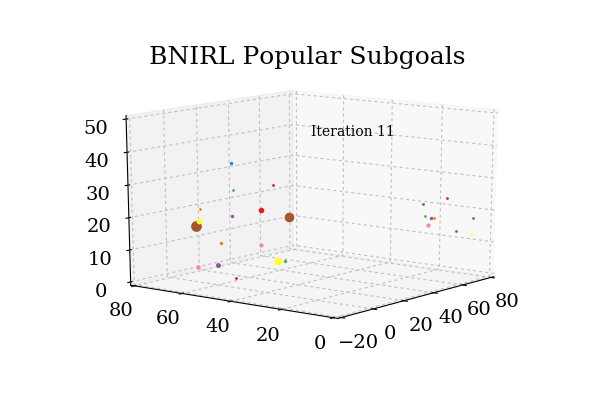

In [57]:
fig = plt.figure()
ax = fig.gca(projection='3d')

def update(i):
    plt.cla()
    modes2, _ = stats.mode(partition_dist[brn:brn+1+i])
    mode_set2 = set([int(mode) for mode in modes2[0]])
    
    for mode in mode_set2:
        c = np.count_nonzero(modes2[0] == mode)
        ax.scatter(*np.split(states_condense_xyz[mode], 3), zdir='z', s=c)
    
    ax.text(60, 60, 40, 'Iteration %i' % i)
    
    excplt.orient_plot(ax)
    plt.title('BNIRL Popular Subgoals')

anim = FuncAnimation(fig, update, frames=np.arange(0, iters-brn), interval=100)
# anim.save('figs/BNIRL_clustering.gif', dpi=80, writer='imagemagick')

### Observation i Posterior 

Illustrate the posterior distribution for observation $O_i$, along with the state-action pair $(s_i, a_i)$.

<IPython.core.display.Javascript object>


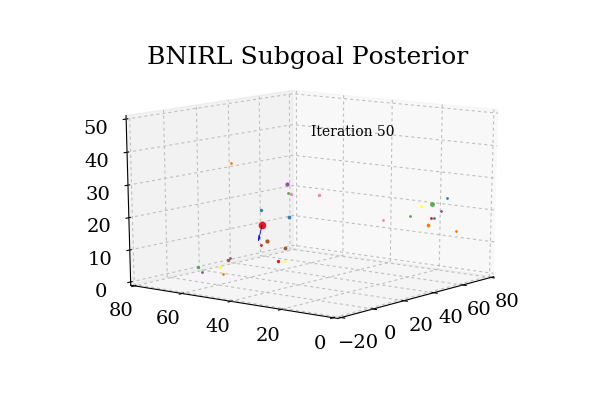

In [58]:
fig = plt.figure()
ax = fig.gca(projection='3d')
obs = 30

args = np.split(states_condense_xyz[obs], 3) + np.split(states_project_xyz[obs] - states_condense_xyz[obs], 3)

def update(i):
    plt.cla()
    samples_i = partition_dist[brn:brn+1+i, obs]
    partition_set = set([int(a) for a in partition_dist[20:21+i, obs]])

    ax.scatter(*np.split(states_condense_xyz[obs], 3), zdir='z')
    ax.quiver(*args, length=6, normalize=True, color='b', linewidth=0.6)
    for partition in partition_set:
        c = np.count_nonzero(samples_i == partition)
        ax.scatter(*np.split(states_condense_xyz[partition], 3), zdir='z', s=c)

    ax.text(60, 60, 40, 'Iteration %i' % i)
    excplt.orient_plot(ax)
    plt.title('BNIRL Subgoal Posterior')

anim = FuncAnimation(fig, update, frames=np.arange(0, iters-brn), interval=100)
# anim.save('figs/BNIRL_observation_clustering.gif', dpi=80, writer='imagemagick')

___

___

## BNIRL in End-Effector Space

Do the same for the end-effector or workspace (wspace).

In [59]:
states_condense_xyz.shape

(161, 3)

In [23]:
states_xyz = kin.forward_kin_array(states)
states_xyz.shape

(1712, 3)

In [24]:
actions_xyz = np.divide(np.diff(states_xyz, axis=0), np.repeat([np.diff(pos[0])], 3, axis=0).T)
actions_xyz

array([[ -1.30556545,   0.        ,  -6.06535704],
       [  3.56355378,   0.        ,   2.3445811 ],
       [ -2.99036921,   0.        ,   2.98444525],
       ..., 
       [  3.80697887,   2.30218416,   2.33279606],
       [  0.        ,   0.        ,   0.        ],
       [         nan,          nan,  24.00941858]])

In [25]:
actions_xyz_smooth = pd.DataFrame(actions_xyz).rolling(min_periods=1, window=10).mean().values

<IPython.core.display.Javascript object>


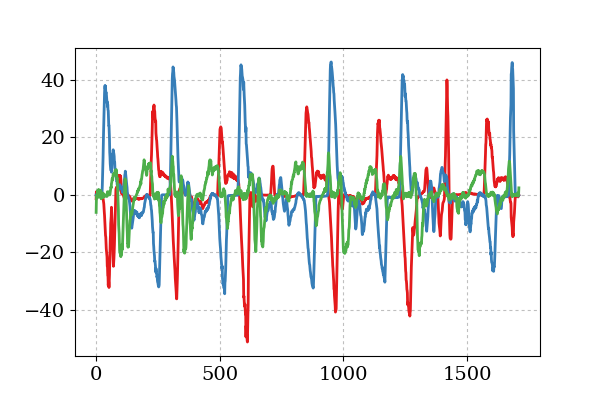

In [170]:
plt.plot(actions_xyz_smooth)

In [26]:
# Actions corresponding to the start of the action classes
actions_condense_xyz = actions_xyz[indexes]
actions_condense_xyz_smooth = actions_xyz_smooth[indexes]

<IPython.core.display.Javascript object>


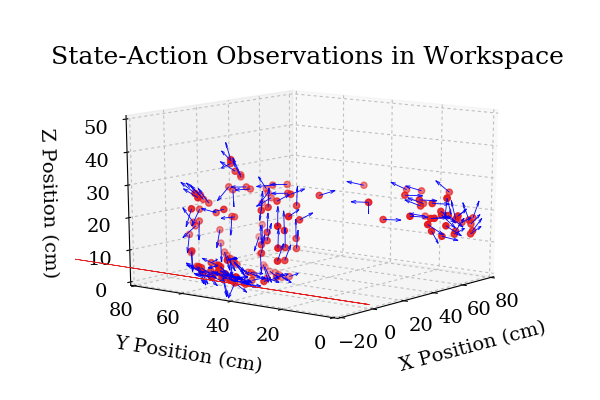

In [179]:
fig = plt.figure()
ax = fig.gca(projection='3d')
args = np.split(states_condense_xyz, 3, axis=1) + np.split(states_condense_xyz + actions_condense_xyz_smooth*1000, 3, axis=1)

plt.title('State-Action Observations in Workspace')
plt.xlabel('X Position (cm)', family='serif', labelpad=15, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=15, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)

ax.scatter(*np.split(states_condense_xyz, 3, axis=1), zdir='z')
ax.quiver(*args, length=6, normalize=True, color='b', linewidth=0.6)

excplt.orient_plot(ax)

# plt.tight_layout()
plt.savefig('figs/state_action_xyz_quiver.pdf', pad_inches=0.5)

In [172]:
# Initialize the subgoal partition labels all to zero, and size to track convergence
partitions = [0]*(len(states_condense_xyz))
iters = 50
partition_dist = np.zeros((iters, len(states_condense_xyz)))
size = np.zeros((iters))

# Run BNIRL for _ iterations # eta works around 1e-11
for i in tqdm(range(iters)):
    partitions = lrn.bnirl_sampling_3(states_condense_xyz, partitions, 
                                      actions_condense_xyz_smooth, verbose=False, 
                                      eta=1e-20)
    partition_dist[i] = np.array(partitions)
    size[i] = (len(set(partitions)))

100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


<IPython.core.display.Javascript object>


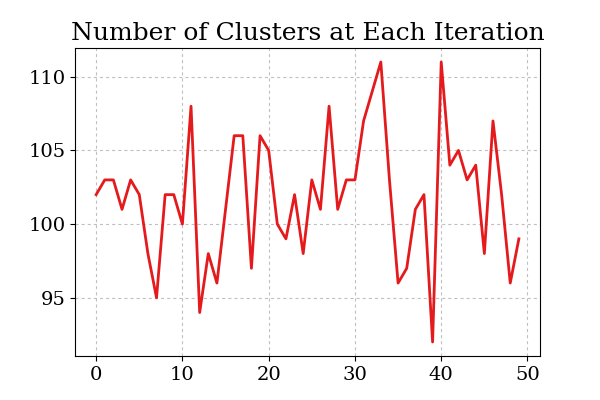

In [173]:
# Not too useful...
plt.figure()
plt.plot(size)
plt.title('Number of Clusters at Each Iteration')

In [174]:
partition_dist.shape

(50, 161)

In [175]:
# Build up modes array with j^th posterior modes *after* i^th iteration
modes = np.zeros(partition_dist.shape)
# modes = np.zeros(len(states_condense))

# Discard iterations for burn-in
brn = 20

# Store mode for each state over Gibbs sampling sweeps up to i^th iteration
for j in tqdm(range(len(partition_dist))): # 0-200
    for i in range(partition_dist.shape[1]): # 0-161
        modes[j, i] = stats.mode(partition_dist[:j+1, i])[0][0]
        
# Set of final mode posteriors and counts array: (mode_num, count)
mode_set = set([int(mode) for mode in modes[-1]])
counts = [(mode, np.count_nonzero(modes[-1]==mode)) for mode in mode_set]

# Top six modes
modes_trim = [x[1] for x in sorted(counts, key=lambda x: x[1])[:-6:-1]]

# Sort by descending counts
sorted(counts, key=lambda x: x[1])[::-1]

100%|██████████| 50/50 [00:05<00:00,  4.96it/s]


[(9, 6),
 (8, 6),
 (3, 6),
 (16, 5),
 (46, 4),
 (34, 4),
 (15, 4),
 (13, 4),
 (109, 3),
 (44, 3),
 (42, 3),
 (32, 3),
 (30, 3),
 (20, 3),
 (144, 3),
 (14, 3),
 (12, 3),
 (7, 3),
 (6, 3),
 (4, 3),
 (1, 3),
 (121, 2),
 (116, 2),
 (101, 2),
 (89, 2),
 (86, 2),
 (82, 2),
 (141, 2),
 (80, 2),
 (59, 2),
 (52, 2),
 (48, 2),
 (38, 2),
 (29, 2),
 (28, 2),
 (26, 2),
 (23, 2),
 (21, 2),
 (5, 2),
 (0, 2),
 (149, 1),
 (126, 1),
 (123, 1),
 (41, 1),
 (115, 1),
 (111, 1),
 (108, 1),
 (107, 1),
 (104, 1),
 (103, 1),
 (98, 1),
 (95, 1),
 (94, 1),
 (93, 1),
 (90, 1),
 (84, 1),
 (35, 1),
 (79, 1),
 (78, 1),
 (76, 1),
 (97, 1),
 (69, 1),
 (67, 1),
 (65, 1),
 (62, 1),
 (61, 1),
 (58, 1),
 (55, 1),
 (54, 1),
 (50, 1),
 (43, 1),
 (135, 1),
 (156, 1),
 (39, 1),
 (37, 1),
 (36, 1),
 (155, 1),
 (33, 1),
 (31, 1),
 (27, 1),
 (25, 1),
 (24, 1),
 (17, 1),
 (10, 1),
 (132, 1)]

<IPython.core.display.Javascript object>


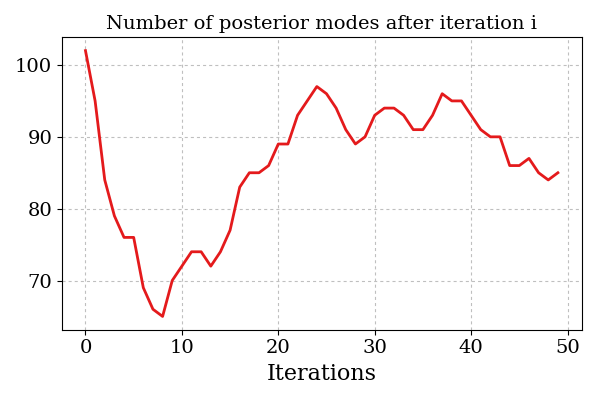

In [176]:
# Visualize number of posterior modes 
plt.figure()
plt.plot([len(set(mode)) for mode in modes])

plt.title('Number of posterior modes after iteration i', fontsize=14)
plt.xlabel('Iterations')

plt.tight_layout()

plt.savefig('figs/BNIRL_posterior_mode_convergence.pdf')

# Visualize BNIRL Subgoals

Compute forward kinematics and visualize subgoals.

In [148]:
# Extract subgoals in XYZ from states in XYZ
# NOTE SUBGOALS ARE ALSO BIASED TO GND FRAME

listed_modes = list(mode_set)
# listed_modes = modes_trim

subgoals_xyz = states_condense_xyz[listed_modes]
subgoals_xyz

array([[ 17.90906118,  62.09824235,  31.2251196 ],
       [ 15.04650208,  65.20601132,  27.50851131]])

<IPython.core.display.Javascript object>


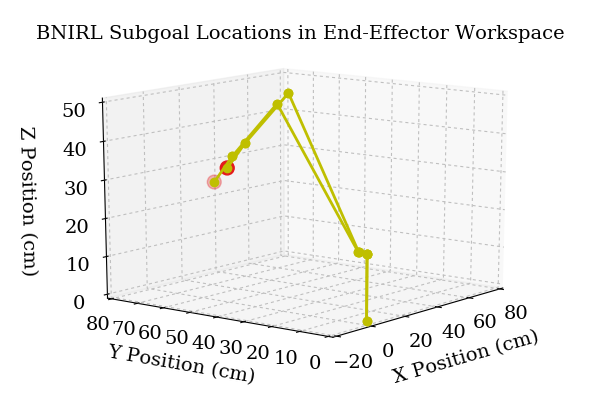

In [149]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('BNIRL Subgoal Locations in End-Effector Workspace', family='serif', fontsize=14)
plt.xlabel('X Position (cm)', family='serif', labelpad=10, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=10, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)
# plt.zlabel('z Position (cm)')

for j in listed_modes:
    trajectories.draw_exc(ax, states_condense[j], lw=2)

ax.scatter(*np.split(subgoals_xyz, 3, axis=1), s=100)

excplt.orient_plot(ax)
plt.tight_layout()
plt.savefig('figs/BNIRL_wspace_subgoals.pdf', pad_inches=0.5)

# Animate demonstration with subgoals

Test the draw_exc() func by animating all states. See exc-render.ipynb for examples of draw_exc(). 

In [323]:
# Mode dict for colors
mode_color = dict()

for i, mode in enumerate(listed_modes):
    mode_color[mode] = i

In [324]:
colors = ['b', 'g', 'r', 'y', 'm', 'c']

Switch matplotlib backend for better GIF writing.

In [75]:
%matplotlib inline

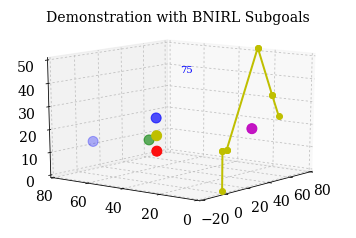

In [326]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# for i in mode_set - set([101, 149]):
#     trajectories.draw_exc(ax, states[i])

def update(i):
    plt.cla()
    plt.title('Demonstration with BNIRL Subgoals', family='serif', fontsize=14)
    ax.scatter(*np.split(subgoals_xyz.T, 3), s=100, 
               c=[colors[mode_color[m] % 5] for m in mode_set])
    excplt.draw_exc(ax, states_condense[i])
    excplt.orient_plot(ax)
    sg_label = int(modes[-1, i])
    ax.text(60, 60, 40, sg_label, color=colors[mode_color[modes[-1, i]] % 5])

anim = FuncAnimation(fig, update, 
                     frames=range(0, len(states_condense)),
                     interval=200)

# plt.show()
anim.save('figs/BNIRL_subgoal_states.gif', dpi=80, writer='imagemagick')

In [74]:
len(states)

1712

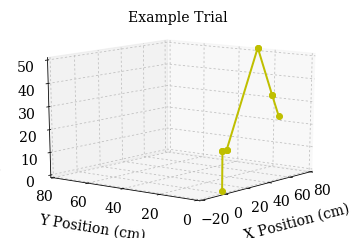

In [78]:
fig = plt.figure()
ax = fig.gca(projection='3d')

savefig_kw = {'pad_inches': 0.5}

# for i in mode_set - set([101, 149]):
#     trajectories.draw_exc(ax, states[i])

def update(i):
    plt.cla()
    plt.title('Example Trial', family='serif', fontsize=14)
#     ax.scatter(*np.split(subgoals_xyz.T, 3), s=100, 
#                c=[colors[mode_color[m] % 5] for m in mode_set])
    excplt.draw_exc(ax, states[i])
    excplt.orient_plot(ax)
    plt.xlabel('X Position (cm)', family='serif', labelpad=15, fontsize=14)
    plt.ylabel('Y Position (cm)', family='serif', labelpad=15, fontsize=14)
    ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)
#     sg_label = int(modes[-1, i])
#     ax.text(60, 60, 40, sg_label, color=colors[mode_color[modes[-1, i]] % 5])

anim = FuncAnimation(fig, update, 
                     frames=np.arange(0, len(states), 10),
                     interval=200)

# plt.show()
anim.save('figs/demo.gif', dpi=80, writer='imagemagick', savefig_kwargs=savefig_kw)

Put it back now, yall

In [346]:
%matplotlib notebook

___

# Animate cluster formation

Show clusters over iteration of Gibbs Sampling

### Popular subgoals

Clusters represent subgoals after i'th iteration, cluster size represents number of states seeking that subgoal after i'th iteration

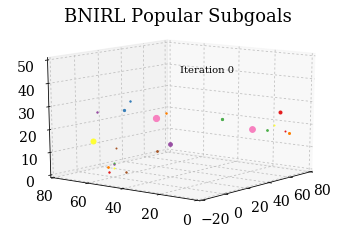

In [332]:
fig = plt.figure()
ax = fig.gca(projection='3d')

def update(i):
    plt.cla()
    modes, _ = stats.mode(partition_dist[brn:brn+1+i])
    mode_set = set([int(mode) for mode in modes[0]])
    
    for mode in mode_set:
        c = np.count_nonzero(modes[0] == mode)
        ax.scatter(*np.split(states_xyz_bias.T[mode], 3), zdir='z', s=c)
    
    ax.text(60, 60, 40, 'Iteration %i' % i)
    
    excplt.orient_plot(ax)
    plt.title('BNIRL Popular Subgoals')

anim = FuncAnimation(fig, update, frames=np.arange(0, iters-brn), interval=100)
anim.save('figs/BNIRL_clustering.gif', dpi=80, writer='imagemagick')

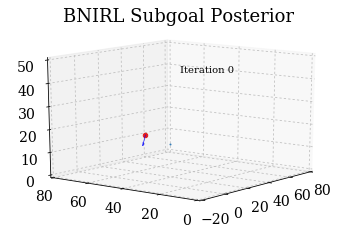

In [331]:
fig = plt.figure()
ax = fig.gca(projection='3d')
obs = 30

args = np.split(states_xyz[obs], 3) + np.split(states_project_xyz[obs] - states_xyz[obs], 3)

def update(i):
    plt.cla()
    samples_i = partition_dist[brn:brn+1+i, obs]
    partition_set = set([int(a) for a in partition_dist[20:21+i, obs]])

    ax.scatter(*np.split(states_xyz[obs], 3), zdir='z')
    ax.quiver(*args, length=6, normalize=True, color='b', linewidth=0.6)
    for partition in partition_set:
        c = np.count_nonzero(samples_i == partition)
        ax.scatter(*np.split(states_xyz[partition], 3), zdir='z', s=c)

    ax.text(60, 60, 40, 'Iteration %i' % i)
    excplt.orient_plot(ax)
    plt.title('BNIRL Subgoal Posterior')

anim = FuncAnimation(fig, update, frames=np.arange(0, iters-brn), interval=100)
anim.save('figs/BNIRL_observation_clustering.gif', dpi=80, writer='imagemagick')

____

# DPMIRL <a class="anchor" id="dpmirl"></a>

Maske, *et. al.*, Dirichlet process means clustering algorithm using DP-means from [Michael Jordan's paper](http://icml.cc/2012/papers/291.pdf)

In [335]:
from sklearn.preprocessing import normalize

In [336]:
states_condense_normal = normalize(states_condense)
states_condense_normal.shape

(161, 4)

In [337]:
states_xyz.shape

(161, 3)

## Cluster in the Actuator Space

Cluster in the normalized actuator space and show subgoals and convergence.

In [352]:
partition_dpk = [0]*len(states_condense)
iters = 20
mse = np.zeros((iters))
sg_means = []

for i in tqdm(range(iters)):
    partition_dpk = lrn.dp_kmeans(states_condense_normal, partition_dpk,
                                  lamb=0.2)
    mse[i], sgs = lrn.compute_means(partition_dpk, states_condense)
    sg_means.append(sgs)

100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


<IPython.core.display.Javascript object>


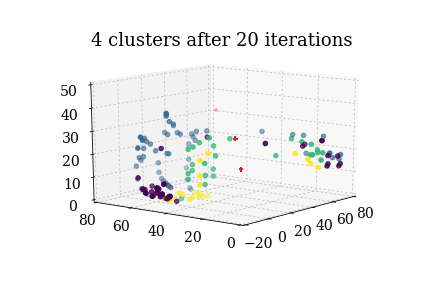

/usr/local/lib/python2.7/site-packages/mpl_toolkits/mplot3d/art3d.py:724: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/usr/local/lib/python2.7/site-packages/mpl_toolkits/mplot3d/art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/usr/local/lib/python2.7/site-packages/mpl_toolkits/mplot3d/art3d.py:728: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif zdir[0] == '-':


In [353]:
fig = plt.figure(figsize=(6, 4))
ax = fig.gca(projection='3d')

plt.title('%i clusters after %i iterations' % (len(set(partition_dpk)), iters))

ax.scatter(*np.split(states_xyz, 3, axis=1), c=partition_dpk, zdir='z')
ax.scatter(*kin.forward_kin_array(sg_means[-1]), marker='+')

excplt.orient_plot(ax)

# plt.subplot(2, 1, 2)
# plt.plot(mse)
# plt.title('Mean Squared Error at i\'th iteration')

<IPython.core.display.Javascript object>


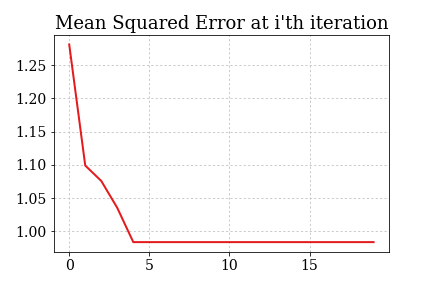

In [354]:
fig = plt.figure()
plt.plot(mse)
plt.title('Mean Squared Error at i\'th iteration')

## Clustering the End-Effector Space

Results in the actuator space are not very good, so we will cluster the end-effector space by tranforming the states first.

In [355]:
states_condense_xyz = kin.forward_kin_array(states_condense)

In [358]:
partition_DPk = [0]*len(states_condense)
iters = 20
mse = np.zeros((iters))
sg_means = []

for i in tqdm(range(iters)):
    partition_DPk = learning.dp_kmeans(states_condense_xyz, partition_DPk, lamb=25.0)
    mse[i], sgs = learning.compute_means(partition_DPk, states_condense)
    sg_means.append(sgs)

100%|██████████| 20/20 [00:03<00:00,  6.01it/s]


<IPython.core.display.Javascript object>


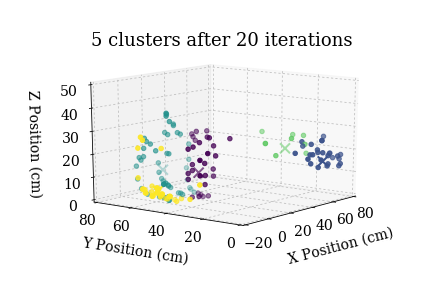

In [365]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('%i clusters after %i iterations' % (len(set(partition_DPk)), iters))

ax.scatter(*np.split(states_xyz_bias, 3), c=partition_DPk, zdir='z')
ax.scatter(*kin.forward_kin_array(sg_means[-1]).T, 
           c=list(set(partition_DPk)), marker='x', s=100)

plt.xlabel('X Position (cm)', family='serif', labelpad=15, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=15, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)

excplt.orient_plot(ax)

plt.savefig('figs/DPMIRL_clusters_wspace.pdf', pad_inches=0.5)

____

<IPython.core.display.Javascript object>


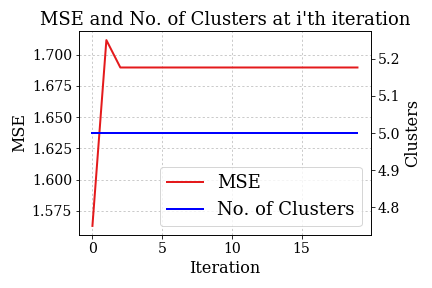

In [363]:
fig = plt.figure()
ax = plt.gca()

ln1 = ax.plot(mse, label='MSE')
ax2 = ax.twinx()
ln2 = ax2.plot([len(sgs) for sgs in sg_means], label='No. of Clusters', c='b')

plt.title('MSE and No. of Clusters at i\'th iteration')

# added these three lines
lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

# ax.grid()
ax2.grid()

ax.set_xlabel("Iteration")
ax.set_ylabel('MSE')
ax2.set_ylabel('Clusters')
plt.tight_layout()

Not much information there....

# Changepoint Detection A-Space

Detect changes in velocity larger than threshold and cluster those states.

In [27]:
# Start with smooth rates and compute accel
rate_sm.shape

(4, 1711)

In [28]:
accel = np.diff(rate_sm).T
accel.shape

(1710, 4)

In [29]:
# Compute norm across axis 1
accel_mag = np.linalg.norm(accel, axis=1)


<IPython.core.display.Javascript object>


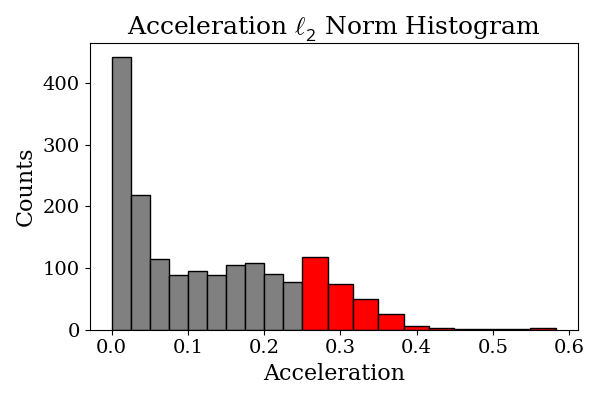

In [73]:
# A histogram will show us what is typical here
plt.hist(accel_mag[accel_mag <= 0.25], color='grey', ec='k')
plt.hist(accel_mag[accel_mag > 0.25], color='r', ec='k')
# plt.hist(accel_mag)
plt.title('Acceleration $\ell_2$ Norm Histogram')
plt.xlabel('Acceleration')
plt.ylabel('Counts')
plt.grid('off')
plt.tight_layout()

plt.savefig('figs/cpts_hist.pdf')

In [31]:
cpts = np.where(accel_mag > 0.25)

<IPython.core.display.Javascript object>


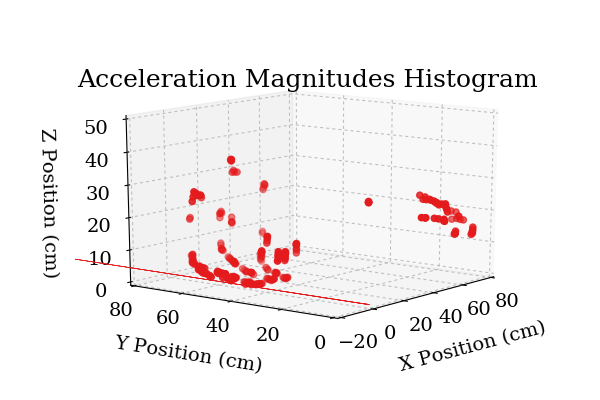

In [59]:
fig = plt.figure()
ax = fig.gca(projection='3d')

plt.title('Changepoints')
plt.xlabel('X Position (cm)', family='serif', labelpad=15, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=15, fontsize=14)
ax.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)

ax.scatter(*np.split(states_xyz[cpts], 3, axis=1), zdir='z')
excplt.orient_plot(ax)

plt.savefig('figs/changepoints.pdf', pad_inches=0.5)

In [33]:
from sklearn import mixture
import itertools

In [46]:
color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold',
                              'darkorange', 'r'])

def plot_results(X, Y_, title):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for i in range(6):
        if not np.any(Y_ == i):
            continue
        ax.scatter(X[Y_ == i, 0], X[Y_ == i, 1], X[Y_ == i, 2], 
                   zdir='z', c=color_iter.next(), zorder=1)

    excplt.orient_plot(ax)
    plt.xlabel('X', labelpad=15)
    plt.ylabel('Y', labelpad=15)
    plt.title(title)
    return ax

In [51]:
gmm = mixture.BayesianGaussianMixture(n_components=8, 
                                      weight_concentration_prior=1e5).fit(states_xyz[cpts])
gmm.n_components

8

In [52]:
glabels = gmm.predict(states_xyz[cpts])

cpts_xyz = states_xyz[cpts]
mean = np.zeros((len(set(glabels)), 3))

for i, lbl in enumerate(set(glabels)):
    mean[i] = np.mean(cpts_xyz[glabels == lbl], axis=0)

mean

array([[-10.07723735,  53.03561121,   6.72131444],
       [ 47.42469341,  -1.87654587,  21.87828638],
       [ 25.12721719,  53.39805462,   1.36957172],
       [  8.53648331,  59.06544171,   2.91170755],
       [ 13.82588664,  63.60382171,  25.06359628],
       [  7.70418013,  40.14631679,  11.12483047],
       [ 41.08755551,  24.84676764,  24.01720825]])

<IPython.core.display.Javascript object>


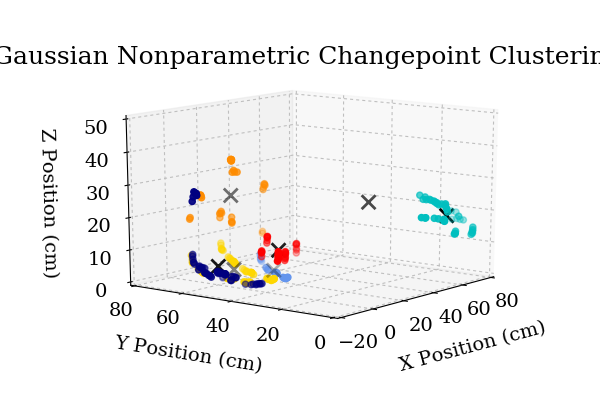

In [58]:
ax3d = plot_results(states_xyz[cpts], gmm.predict(states_xyz[cpts]),
             'Gaussian Nonparametric Changepoint Clustering')
ax3d.scatter(*np.split(mean, 3, axis=1), marker='x', c='k', s=100)
plt.xlabel('X Position (cm)', family='serif', labelpad=15, fontsize=14)
plt.ylabel('Y Position (cm)', family='serif', labelpad=15, fontsize=14)
ax3d.set_zlabel('Z Position (cm)', family='serif', labelpad=10, fontsize=14)

plt.savefig('figs/cpt_clusters.pdf', pad_inches=0.5)

## TODO

Try a tutorial with Gaussian non-parametric clustering and see how the cluster count responds to changes in hyperparameter